In [638]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import numba
from sklearn.cluster import KMeans

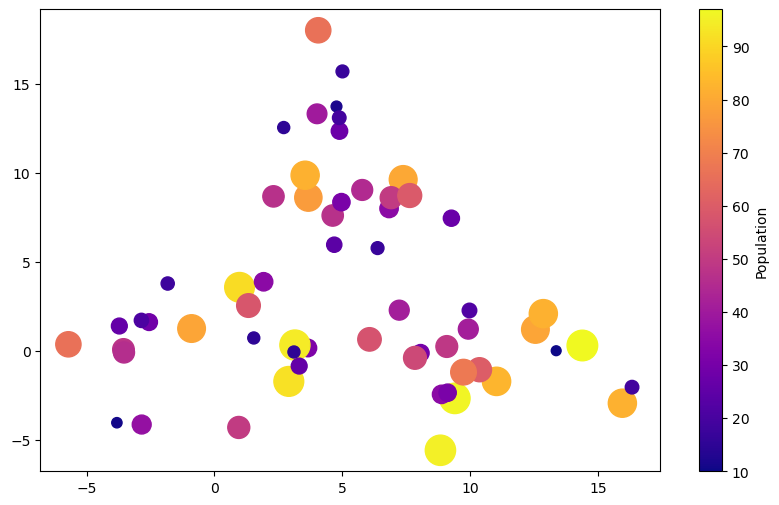

In [639]:
centers = np.array([[0, 0], [10, 0], [5, 10]])

# Générer les points à l'intérieur de chaque cluster
points_per_cluster = 20
points = []

for center in centers:
    # Générer des points aléatoires autour du centre du cluster
    cluster_points = np.random.normal(loc=center, scale=3, size=(points_per_cluster, 2))
    points.extend(cluster_points)

points = np.array(points)
xp = points[:, 0]
yp = points[:, 1]


population = np.random.randint(10, 101, size = 3*20)
size = population*5
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
sc = ax.scatter(xp, yp, c=population, cmap='plasma',
                s=size, zorder=3)
plt.colorbar(sc, label='Population')



In [699]:
Hs = 1
N = 18
n_clusters = 3
Is = 10
Imin = 0.1
ImaxSol = Imin*2

I_min_sol = 5
p = 100


In [641]:
@numba.jit(nopython = True)
def sigmoid(x, center = 0, M = 100) : 
    return 1/(1+np.exp(-M*(x-center)))

@numba.jit(nopython = True)
def pyth(x1, x2, y1, y2) : 
    return (x2-x1)**2 + (y2-y1)**2

In [642]:
x_min = np.min(xp)
x_max = np.max(xp)

y_min = np.min(yp)
y_max = np.max(yp)

@numba.jit(nopython = True, parallel = True)
def objectif(x) :
    return 0

        
    
    

@numba.jit(nopython = True, parallel = True)
def contrainte1(x) : 
    somme = 0
    for j in numba.prange(len(population)) : 
        sumj = 0
        for i in numba.prange(int(len(x)/2)) : 
            dij_sq = pyth(xp[j], x[2*i], yp[j], x[2*i+1]) + Hs**2
            sumj += Is/(dij_sq)
            
        somme += sigmoid(sumj/population[j], center = Imin, M = 1e2)*population[j]
    return somme/sum(population)






In [643]:
P = np.vstack((xp, yp)).T

kmeans = KMeans(n_clusters=n_clusters, init = "k-means++", n_init = 100)
    #n_clusters = nombre de clusters avec lequel on travaille
    #init = méthode d'initialisation des centroides, "random" ça veut dire que les centroides sont placés en mode random et "k-means++" c'est une méthode qui donne des centroides optimisés
    #n_init = nombre de fois que l'algorithme va tourner et donner la meilleure solution


kmeans.fit(P,sample_weight = population)
y_kmeans = kmeans.predict(P, sample_weight = population)

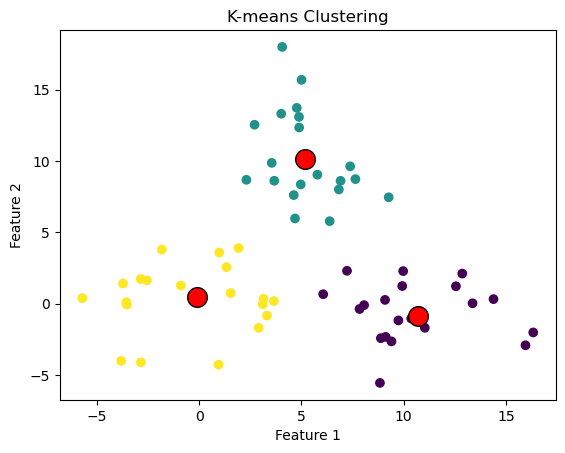

In [644]:
# Visualiser les clusters
plt.scatter(P[:, 0], P[:, 1], c=y_kmeans, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker='o', s=200, edgecolor='k', c='red')
plt.title('K-means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [645]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint, LinearConstraint
import time
import numpy as np

myc1 = NonlinearConstraint(contrainte1, 0.80, 1)
contraintes = [myc1]
centers = kmeans.cluster_centers_

centers = centers.reshape(n_clusters*2)
x0 = np.tile(centers, int(N/n_clusters))



t0 = time.time()
resultat = minimize(objectif, x0, method='SLSQP', constraints = contraintes)
print("temps : ", time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
print("Valeur de la contrainte 1 : ", contrainte1(resultat.x))

temps :  0.7872247695922852
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0
       x: [ 1.204e+01  1.746e+00 ...  9.023e-03  2.487e+00]
     nit: 36
     jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
    nfev: 1397
    njev: 36
Résultat de l'optimisation: 0
Valeurs optimales des variables: [ 1.20424170e+01  1.74551087e+00  5.34548744e+00  1.00931860e+01
  1.98306116e+00  3.22208803e+00  9.97986700e+00 -2.45370716e+00
  5.29925374e+00  1.00868066e+01  1.87626146e+00  2.27111682e+00
  1.42156668e+01  3.10848772e-01  5.30780924e+00  1.00845058e+01
 -9.69586166e-01  2.35031678e+00  1.11390458e+01 -8.07359539e-01
  5.35011012e+00  1.00888851e+01 -5.20859962e+00  5.22441489e-01
  9.06129395e+00 -4.42920338e+00  5.38917280e+00  1.00801789e+01
  6.25442689e-01  2.48775980e+00  3.64906544e+00  1.02576022e+00
  5.34245720e+00  1.00927736e+01  9.02267594e-03  2.48658893e+00]
Valeur de la contrainte 1 :  0.7999999994024215


/Users/adammesbahi/anaconda3/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../var/folders/g7/ns5n8gvs4pn0vkl_qlxflbkc0000gn/T/ipykernel_1255/4261307201.py", line 7:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


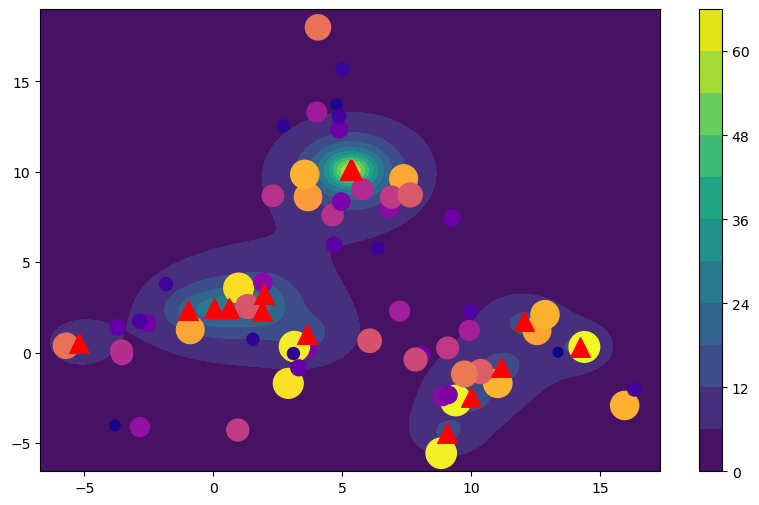

In [646]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += Is/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(np.min(xp)-1, np.max(xp)+1, 1000)
y = np.linspace(np.min(yp)-1, np.max(yp)+1, 1000)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=10, cmap='viridis')
plt.colorbar(cf, ax = ax)
ax.scatter(xp, yp, c=population, cmap='plasma', s=size)
for i in range(N) : 
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "red", s = 200, label = "sattelites")



Maintenant on va considérer exactement le même problème mais maintenant on va essayer de poser des zones interdites. Dans notre cas présent, on va considérer une zone circulaire la ou bcp de satellites se sont rassembles comme ça on les force à se repartir autour

In [647]:
from scipy.optimize import minimize, Bounds

centre_cercle = [5, 10]
r = 2



myc1 = NonlinearConstraint(contrainte1, 0.80, 1)
contraintes = list()

function_forbidden = list()




centers = kmeans.cluster_centers_

centers = centers.reshape(n_clusters*2)
x0 = np.tile(centers, int(N/n_clusters))

def contrainte_forbidden(x) : 
    result = np.zeros(int(len(x)/2))
    for i in range(int(len(x)/2)) : 
        result[i] = (x[2*i]-centre_cercle[0])**2 + (x[2*i+1]-centre_cercle[1])**2 - r**2
    return result


myc2 = NonlinearConstraint(contrainte_forbidden, 0, np.inf)
contraintes = [myc1, myc2]

t0 = time.time()
resultat = minimize(objectif, x0, method='SLSQP', constraints = contraintes)
print("temps : ", time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
print("Valeur de la contrainte 1 : ", contrainte1(resultat.x))
print("Valeur de la contrainte 2 : ", contrainte_forbidden(resultat.x))

temps :  0.1182699203491211
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0
       x: [ 9.584e+00 -3.101e+00 ... -5.214e+00  4.888e-01]
     nit: 31
     jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
    nfev: 1194
    njev: 31
Résultat de l'optimisation: 0
Valeurs optimales des variables: [ 9.58436862 -3.10093683  3.74002718  7.8784947   1.41033583  3.71207368
  8.34318892 -2.02157031  6.98461291  8.44871934  2.83758553 -1.56341895
 12.80818958  2.36323205  6.96379493  8.40269556 -2.97958565 -0.58331006
 10.93782135 -1.70466978  7.99326591  0.93903221  5.73650644  4.42780623
 13.9359882   0.13293516  3.36155626  7.92921147  3.06639421  0.85751053
  4.7022043  -0.6960705   7.20699335  2.93498483 -5.2139918   0.48878266]
Valeur de la contrainte 1 :  0.800000847567111
Valeur de la contrainte 2 :  [188.65098157   2.08831628  48.42370628 151.6950648    2.34516011
 134.38869412 115.28804925   2.407872   171.68023911 168.2570171
  87.06077817  2

/var/folders/g7/ns5n8gvs4pn0vkl_qlxflbkc0000gn/T/ipykernel_1255/2185554375.py:33: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle_inner = plt.Circle(center, radius - 0.2, color='none', fill=True, hatch='/', edgecolor='black', linewidth=0.5)


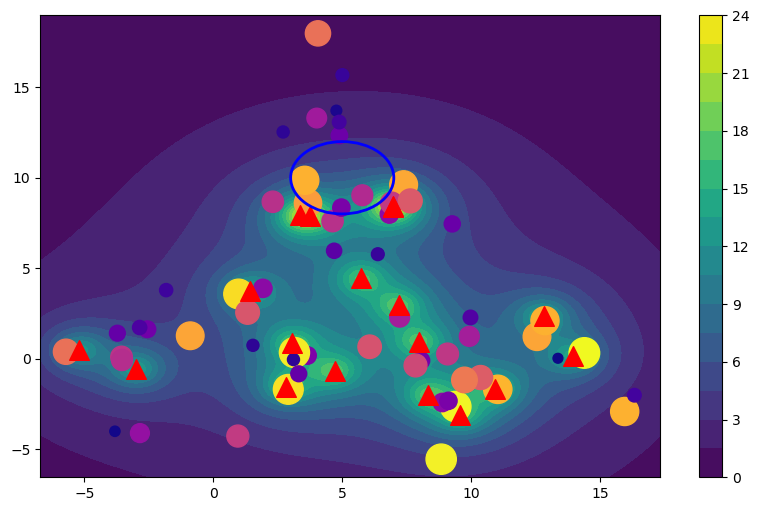

In [648]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += Is/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(np.min(xp)-1, np.max(xp)+1, 1000)
y = np.linspace(np.min(yp)-1, np.max(yp)+1, 1000)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(cf, ax = ax)
ax.scatter(xp, yp, c=population, cmap='plasma', s=size)
for i in range(N) : 
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "red", s = 200, label = "sattelites")
radius = r
center = (centre_cercle[0], centre_cercle[1])

# Tracer le cercle extérieur
circle_outer = plt.Circle(center, radius, color='b', fill=False, linewidth=2)
ax.add_artist(circle_outer)

# Tracer le cercle intérieur hachuré
circle_inner = plt.Circle(center, radius - 0.2, color='none', fill=True, hatch='/', edgecolor='black', linewidth=0.5)
ax.add_artist(circle_inner)

On va considérer une autre contrainte basé sur le confort. Nous savons tous que les ondes peuvent avoir des effets néfastes sur la santé des individus. Sachant que l'intensité est maximale en dessous de chaque satellite, on va imposer que l'intensité en dessous de chaque satellite ne soit pas supérieur à un certain seuil $I_{maxSol}$

In [706]:
from scipy.optimize import minimize
import numba
from scipy.optimize import NonlinearConstraint, LinearConstraint
import time
import numpy as np



def f_sol(x):
    
    result = np.zeros(len(population))
    for i in range(len(population)) : 
        somme = 0
        for j in numba.prange(N) : 
            dij_sq = pyth(xp[i], x[2*j], yp[i], x[2*j+1]) + Hs**2
            somme += Is/(dij_sq) 
        result[i] = somme/population[i]
    return result
        
        

myc1 = NonlinearConstraint(contrainte1, 0.80, 1)
myc2 = NonlinearConstraint(f_sol, 0, Imin*5)

contraintes = [myc1, myc2]
centers = kmeans.cluster_centers_

centers = centers.reshape(n_clusters*2)
x0 = np.tile(centers, int(N/n_clusters))



t0 = time.time()
resultat = minimize(objectif, x0, method='SLSQP', constraints = contraintes)
print("temps : ", time.time()-t0)
print(resultat)
print("Résultat de l'optimisation:", resultat.fun)
print("Valeurs optimales des variables:", resultat.x)
print("Valeur de la contrainte 1 : ", contrainte1(resultat.x))
print("Valeur de la contrainte 2 : ", f_sol(resultat.x))

temps :  0.20283293724060059
 message: Positive directional derivative for linesearch
 success: False
  status: 8
     fun: 0
       x: [-6.038e+04 -5.636e+06 ... -5.438e+06 -9.925e+06]
     nit: 6
     jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
    nfev: 74
    njev: 2
Résultat de l'optimisation: 0
Valeurs optimales des variables: [  -60375.16415774 -5635585.12542664  -333075.74957439 -4165103.95511819
  5679664.95186965  2201786.55465675   -60375.16415774 -5635585.12542664
  -333075.74957439  7301437.96705729 -5786876.97030584  1246676.49072947
   -60375.16415774 -5592593.63479495  -333075.74957439  7301437.96705729
 -5786876.97030584  2158795.06402448    60395.64353456 -5662447.39465741
  -376067.24020314 -4191966.22359776  5652802.68323984  2158795.06402448
    60395.64353456 11263106.76880413  -376067.24020314 -4165103.95511819
  5679664.95186965  2158795.06402448    60395.64353456 11263106.76880413
  1751389.51800374 -2080638.68769031 -5438386.69095145 -9924849.486922

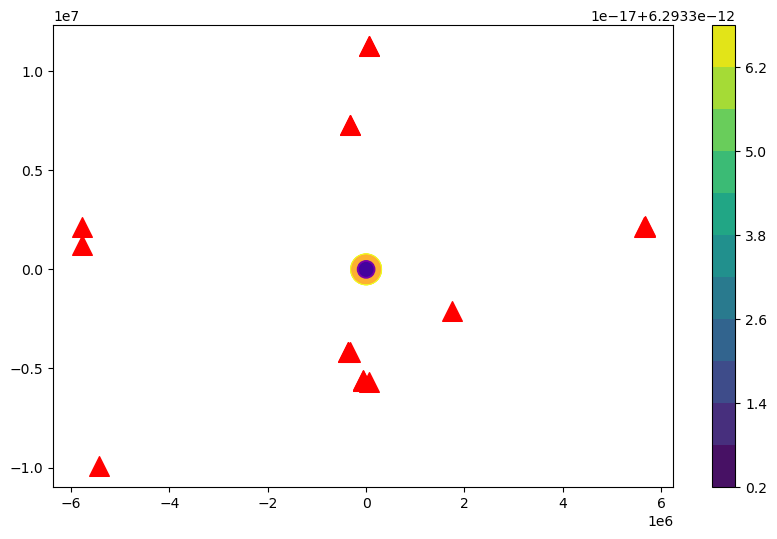

In [707]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

def f(x, y, sol):
    somme = 0
    for i in numba.prange(N) : 
        dij_sq = pyth(x, sol[2*i], y, sol[2*i+1]) + Hs**2
        somme += Is/(dij_sq) 
    return somme

# Générer des points dans le domaine [0, 1] x [0, 1]
x = np.linspace(np.min(xp)-1, np.max(xp)+1, 1000)
y = np.linspace(np.min(yp)-1, np.max(yp)+1, 1000)
X, Y = np.meshgrid(x, y)

# Calculer les valeurs de la fonction f(x, y) pour chaque point
Z = f(X, Y, resultat.x)


cf = ax.contourf(X, Y, Z, levels=10, cmap='viridis')
plt.colorbar(cf, ax = ax)
ax.scatter(xp, yp, c=population, cmap='plasma', s=size)
for i in range(N) : 
    ax.scatter(resultat.x[2*i], resultat.x[2*i+1], marker = "^", color = "red", s = 200, label = "sattelites")


mmmh complique complique complique ...

On passe sur un autre notebook mdr
